# AutoEncoder on TCGA Gene Expression

In [28]:
# utils
%load_ext autoreload
%autoreload 1

import sys
import os
sys.path.append("../utils/")
%aimport utils

# sklearn utilities
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# classifiers
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer
import sklearn.metrics as metrics
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

# keras
from keras import backend as K
from keras.models import Model, Input
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

n_cores = 10

K.set_session(K.tf.Session(config=K.tf.ConfigProto(
    intra_op_parallelism_threads=n_cores, 
    inter_op_parallelism_threads=n_cores)))

# math
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

models_path = "./models/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading all TCGA dataset

In [15]:
def load_PANCAN_TCGA(path="./data/PANCAN_raw/", 
                     geneexp_name="batchRemoved", 
                     clinical_name="clinicalMatrix",
                     sample_types_name="sample_type"):
    print("LOADING GENE EXPRESSION")
    tcga = load_geneexp_data(os.path.join(path, "PANCAN_{}.tsv".format(geneexp_name)))
    print("LOADING CLINICAL DATA")
    clinical = load_clinical_data(os.path.join(path, "PANCAN_{}.tsv".format(clinical_name)))
    print("LOADING SAMPLE INFORMATION")
    sample_types = load_sample_types(os.path.join(path, "PANCAN_{}.tsv".format(sample_types_name)))
    
    tcga_samples = set(tcga.index.tolist())
    clinical_samples = set(clinical.index.tolist())
    sample_types_samples = set(sample_types.index.tolist())
    
    sample_intersection = list(tcga_samples.intersection(clinical_samples)\
                               .intersection(sample_types_samples))
    
    tcga = tcga.loc[tcga.index.intersection(sample_intersection)].sort_index()
    clinical = clinical.loc[clinical.index.intersection(sample_intersection)].sort_index()
    sample_types = sample_types.loc[sample_types.index.intersection(sample_intersection)].sort_index()
    return tcga, clinical, sample_types
    

def load_geneexp_data(path="./data/PANCAN_raw/PANCAN_batchRemoved.tsv"):
    print("Loading expression data")
    tcga = pd.read_csv(path, sep="\t")
    # remove the NaN values due to batch-normalization
    print("Removing NaN values (filling with zero)")
    tcga = tcga.fillna(0)
    # there is a gene which has multiple occurrencies. 
    # We deal with it by doing the mean of counts.
    print("Grouping duplicated genes by mean")
    tcga = tcga.groupby(by="sample").mean()
    # give a name to the gene index
    tcga.index.rename("gene_symbol", inplace=True)
    # give a name to the patient index
    tcga.columns.rename("sample", inplace=True)
    # convert to patient x gene matrix
    print("Transpose and sort the data")
    tcga = tcga.T
    # sort the patient index
    tcga.sort_index(axis=0, inplace=True)
    # sort the gene index
    tcga.sort_index(axis=1, inplace=True)
    return tcga


def load_clinical_data(path="./data/PANCAN_raw/PANCAN_clinicalMatrix.tsv"):
    clinical = pd.read_csv(path, sep="\t")
    clinical.set_index("sample", inplace=True)
    return clinical


def load_sample_types(path="./data/PANCAN_raw/PANCAN_sample_type.tsv"):
    sample_types = pd.read_csv(path, sep="\t")
    sample_types.set_index("sample", inplace=True)
    return sample_types


def to_matrix(tcga):
    idx_to_sample = pd.Series(data=tcga.index.tolist(), index=np.arange(tcga.shape[0], dtype=int))
    idx_to_gene = pd.Series(data=tcga.columns.tolist(), index=np.arange(tcga.shape[1], dtype=int))
    m = tcga.as_matrix()
    return m, idx_to_sample, idx_to_gene


def save_dataset_to_matrix(tcga, clinical, sample_types,
                           path="./data/PANCAN_preprocessed/"):
    os.makedirs(path, exist_ok=True)
    # save gene expression
    m, idx_to_sample, idx_to_gene = to_matrix(tcga)
    np.save(os.path.join(path, "data_preprocessed"), m)
    idx_to_sample.to_csv(os.path.join(path, "idx_to_sample.csv"), index=True, header=False)
    idx_to_gene.to_csv(os.path.join(path, "idx_to_gene.csv"), index=True, header=False)
    
    # save clinical
    clinical.to_csv(os.path.join(path, "clinical_preprocessed.csv"), index=True, header=True)
    # save sample_types
    sample_types.to_csv(os.path.join(path, "sample_types_preprocessed.csv"), index=True, header=True)

    
def load_PANCAN_TCGA_from_matrix(path="./data/PANCAN_preprocessed/"):
    m = np.load(os.path.join(path, "data_preprocessed.npy"))
    idx_to_sample = pd.read_csv(os.path.join(path, "idx_to_sample.csv"), 
                                index_col=0, header=None, squeeze=True)
    idx_to_gene = pd.read_csv(os.path.join(path, "idx_to_gene.csv"), 
                              index_col=0, header=None, squeeze=True)
    
    clinical = pd.read_csv(os.path.join(path, "clinical_preprocessed.csv"), 
                           index_col=0)
    sample_types = pd.read_csv(os.path.join(path, "sample_types_preprocessed.csv"), 
                               index_col=0)
    
    return m, idx_to_sample, idx_to_gene, clinical, sample_types

### Basic pre-processing

In [ ]:
# tcga, clinical, sample_types = load_PANCAN_TCGA()
# print("----- Saving the data -----")
# save_dataset_to_matrix(tcga, clinical, sample_types)

### Using pre-processed data

In [ ]:
X, idx_to_sample, idx_to_gene, clinical, sample_types = load_PANCAN_TCGA_from_matrix()
y = sample_types._primary_disease.tolist()

## Loading KIRC dataset

In [16]:
X_path = "./data/KIRC_gene_exp.tsv"
X_meta_path = "./data/KIRC_clinicalMatrix.tsv"

X, y, _, _, idx_to_gene_cohort, _ = utils.load_stage_data(X_path, X_meta_path)

# reordering of X genes because it is different from TCGA
idx_to_gene_cohort = idx_to_gene_cohort.sort_values()
X = X[:, idx_to_gene_cohort.index.tolist()]
idx_to_gene_cohort = idx_to_gene_cohort.reset_index(drop=True)

# patients with Primary Tumor and Stage I, Stage II, Stage III, Stage IV: 531


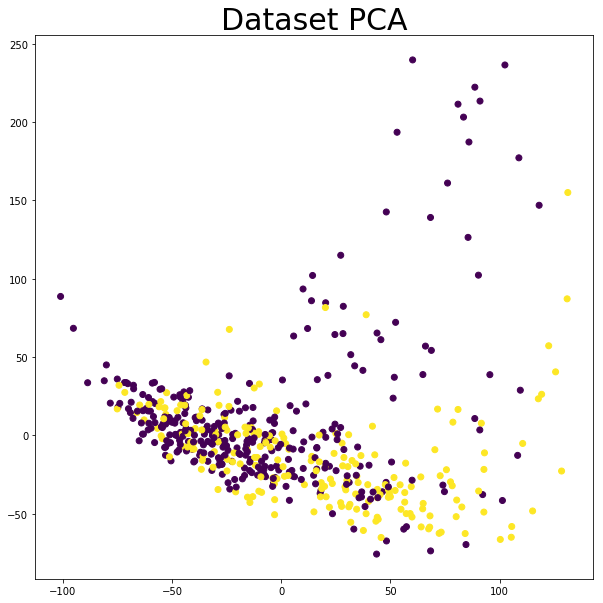

In [17]:
plt.figure(figsize=(10, 10))
utils.plot_PCA(X, y)
plt.title("Dataset PCA", fontsize=30)
plt.show()

## Statistics

### Variance

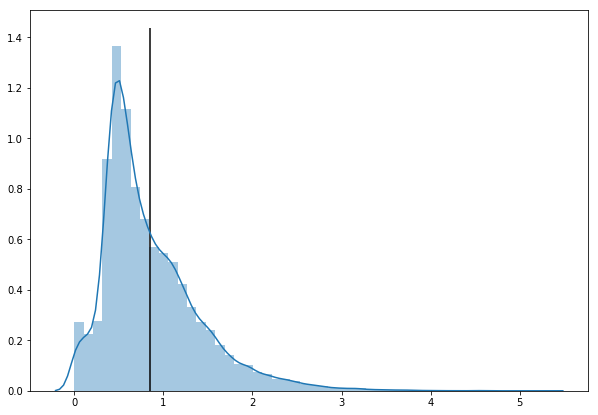

# Zero-std genes: 286


In [18]:
genes_std = X.std(0)
mean_genes_std = np.mean(genes_std)

plt.figure(figsize=(10, 7))
sns.distplot(genes_std)
ymin, ymax = plt.ylim()
plt.vlines([mean_genes_std], ymin=ymin, ymax=ymax)
plt.show()

# number of genes with zero std
n_genes_zero_std = genes_std[genes_std == 0].shape[0]
print("# Zero-std genes: {}".format(n_genes_zero_std))

### Mean

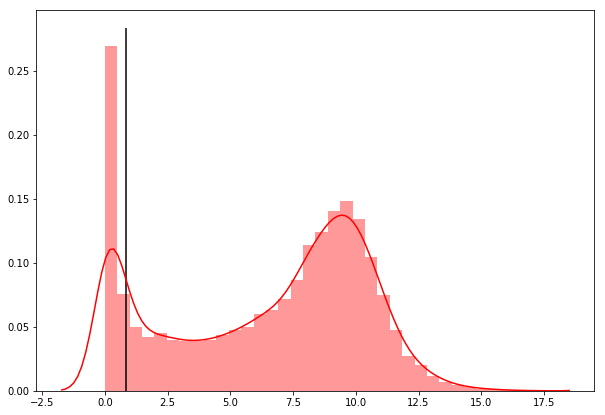

# Zero-mean genes: 286


In [19]:
genes_mean = X.mean(0)
mean_genes_mean = np.mean(genes_std)

plt.figure(figsize=(10, 7))
sns.distplot(genes_mean, color="red")
ymin, ymax = plt.ylim()
plt.vlines([mean_genes_mean], ymin=ymin, ymax=ymax)
plt.show()

# number of genes with zero mean
n_genes_zero_mean = genes_mean[genes_mean == 0].shape[0]
print("# Zero-mean genes: {}".format(n_genes_zero_mean))

### Median absolute deviation

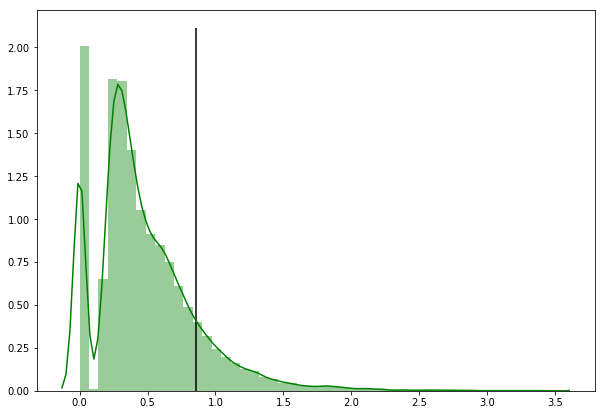

In [20]:
genes_median = np.median(X, axis=0)
genes_mad = np.median(np.abs(X - genes_median), axis=0)

mean_genes_mad = genes_mad.mean()

plt.figure(figsize=(10, 7))
sns.distplot(genes_mad, color="green")
ymin, ymax = plt.ylim()
plt.vlines([mean_genes_mean], ymin=ymin, ymax=ymax)
plt.show()

## Pre-processing

Taking the top genes by MAD

In [21]:
top_k = 5000
genes_top_idxs = np.argsort(genes_mad)[::-1][:top_k]
X_t = X[:, genes_top_idxs]

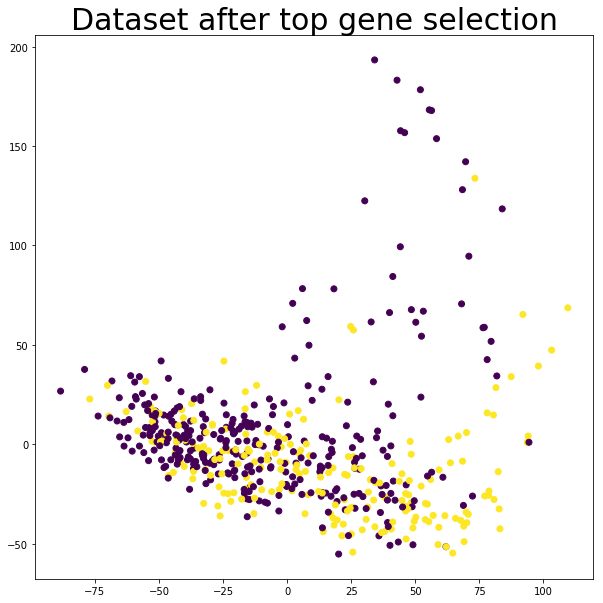

In [22]:
plt.figure(figsize=(10, 10))
utils.plot_PCA(X_t, y)
plt.title("Dataset after top gene selection", fontsize=30)
plt.show()

Scaling the shit out of it...

In [23]:
scaler = MinMaxScaler()
scaler.fit(X_t)
X_t = scaler.transform(X_t)

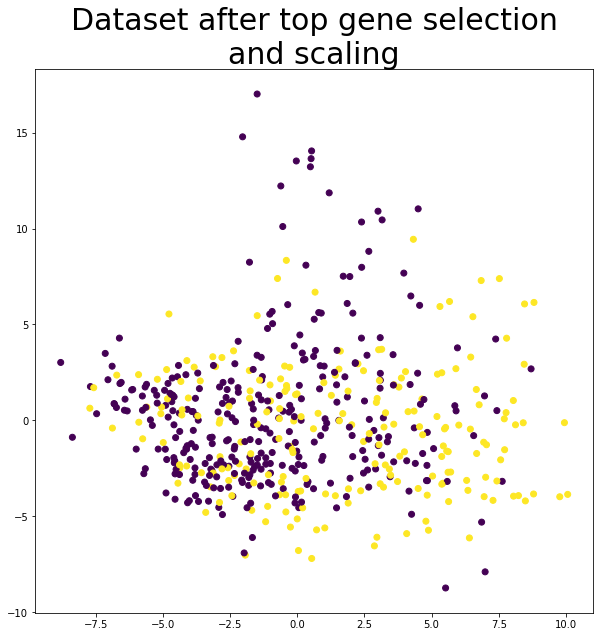

In [24]:
plt.figure(figsize=(10, 10))
utils.plot_PCA(X_t, y)
plt.title("Dataset after top gene selection\nand scaling", fontsize=30)
plt.show()

## AutoEncoder definition

In [25]:
input_shape = X_t.shape[1]
dropout1_ratio = 0.2
e1_dim = 1000
encoding_dim=100
d1_dim = 1000


def visualize_model(model):
    return SVG(model_to_dot(model, 
                            show_shapes=True, 
                            show_layer_names=True).create(prog='dot', format='svg'))

def simple_AE():
    encoder_input = Input(shape=(input_shape,), name="input")
    embedding = Dense(encoding_dim, activation="relu", kernel_initializer='random_uniform',
                      bias_initializer='random_uniform', name="h1")(encoder_input)
    decoder = Dense(input_shape, activation="sigmoid", kernel_initializer='random_uniform',
                    bias_initializer='random_uniform', name="output")(embedding)
    
    autoencoder = Model(inputs=encoder_input, outputs=decoder, name="autoencoder")
    encoder = Model(inputs=encoder_input, outputs=embedding) 
    autoencoder.compile(optimizer='adam', loss='mse')
    return encoder, autoencoder

def simple_AE_with_BatchNormalization():
    encoder_input = Input(shape=(input_shape,), name="input")
    embedding = Dense(encoding_dim, kernel_initializer='glorot_uniform',
                      bias_initializer='glorot_uniform', name="h1")(encoder_input)
    embedding = BatchNormalization(name="Batch_Normalization")(embedding)
    embedding = Activation("relu")(embedding)
    decoder = Dense(input_shape, activation="sigmoid", kernel_initializer='glorot_uniform',
                    bias_initializer='glorot_uniform', name="output")(embedding)
    
    autoencoder = Model(inputs=encoder_input, outputs=decoder, name="autoencoder")
    encoder = Model(inputs=encoder_input, outputs=embedding) 
    autoencoder.compile(optimizer='adam', loss='mse')
    return encoder, autoencoder


def medium_AE_with_BatchNormalization():
    encoder_input = Input(shape=(input_shape,), name="input")
    
    embedding = Dense(e1_dim, kernel_initializer='glorot_uniform',
                      bias_initializer='glorot_uniform', name="h1")(encoder_input)
    embedding = BatchNormalization(name="Batch_Normalization_1")(embedding)
    embedding = Activation("relu")(embedding)
    
    embedding = Dense(encoding_dim, kernel_initializer='glorot_uniform',
                      bias_initializer='glorot_uniform', name="h2")(embedding)
    embedding = BatchNormalization(name="Batch_Normalization_2")(embedding)
    embedding = Activation("relu")(embedding)
    
    decoder = Dense(input_shape, activation="sigmoid", kernel_initializer='glorot_uniform',
                    bias_initializer='glorot_uniform', name="output")(embedding)
    
    autoencoder = Model(inputs=encoder_input, outputs=decoder, name="autoencoder")
    encoder = Model(inputs=encoder_input, outputs=embedding) 
    autoencoder.compile(optimizer='adam', loss='mse')
    return encoder, autoencoder


def create_sparse_autoencoder(input_shape, encoding_dim=100):
    encoder_input = Input(shape=(input_shape,), name="encoder_input")
    dropout1 = Dropout(dropout1_ratio)(encoder_input)
    e1 = Dense(e1_dim, activation="relu", kernel_initializer='random_uniform',
               bias_initializer='random_uniform', name="embedding_layer_1")(dropout1)
    dropout2 = Dropout(dropout1_ratio)(e1)
    embedding = Dense(encoding_dim, activation="relu", kernel_initializer='random_uniform',
                      bias_initializer='random_uniform', name="embedding_layer_2")(dropout2)
    dropout3 = Dropout(dropout1_ratio)(embedding)
    d1 = Dense(d1_dim, activation="relu", kernel_initializer='random_uniform',
               bias_initializer='zeros', name="decoding_layer_1")(dropout3)
    dropout4 = Dropout(dropout1_ratio)(d1)
    decoder_h = Dense(input_shape, activation="sigmoid", kernel_initializer='random_uniform',
                      bias_initializer='random_uniform', name="decoding_layer_2")
    decoded = decoder_h(d1)
    dropout5 = Dropout(dropout1_ratio)(decoded)
    autoencoder = Model(inputs=encoder_input, outputs=decoded, name="autoencoder")
    
    encoder = Model(inputs=encoder_input, outputs=embedding) 
    # compilation
    autoencoder.compile(optimizer='adam', loss='mse')
    return encoder, autoencoder

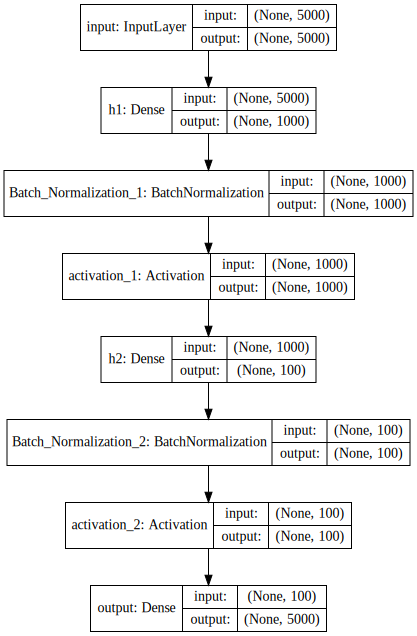

In [26]:
K.clear_session()
encoder, autoencoder = medium_AE_with_BatchNormalization()
visualize_model(autoencoder)

### Training

In [30]:
epochs = 100
batch_size = 20
validation_split = 0.2

model_name = "TCGA_AE_BN_{}".format(utils.time.strftime('%Y_%m_%d__%H_%M'))
history = autoencoder.fit(X_t, X_t, verbose=0,
                          shuffle=True,
                          epochs=epochs,
                          validation_split=validation_split,
                          callbacks=[utils.get_tensorboard_callback(session_name="TCGA_AE_BN"), 
                                     EarlyStopping(patience=20),
                                     ModelCheckpoint(filepath=os.path.join(models_path, model_name),
                                                     save_best_only=True)])

**Warining**
Here we transform the whole training set before doing the training with the classifier for the specific tumor. This introduce a little bias in the results...but I think that for now this can be skipped due to time. 

In [32]:
encoded_X = encoder.predict(X_t)

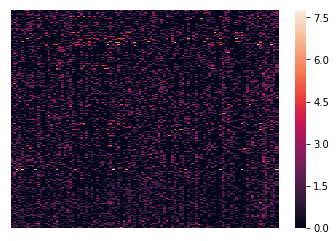

In [33]:
plt.figure()
sns.heatmap(encoded_X, xticklabels=False, yticklabels=False)
plt.show()

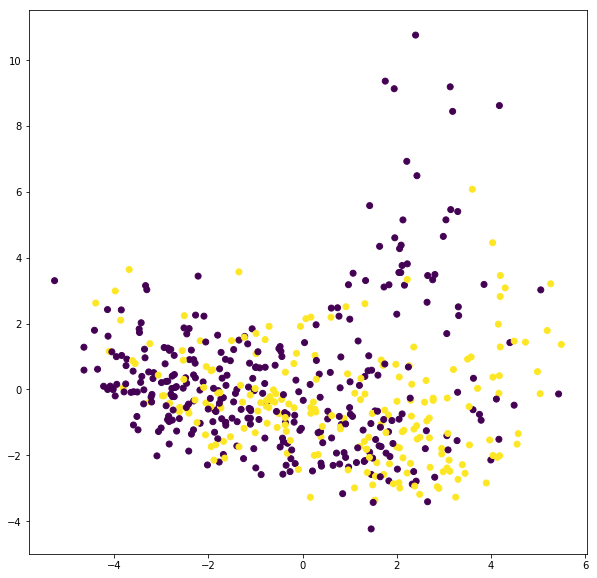

In [34]:
plt.figure(figsize=(10, 10))
utils.plot_PCA(encoded_X, y)
plt.show()

In [35]:
decoded_X = autoencoder.predict(X_t)

In [36]:
diffs = np.abs(decoded_X - X_t).flatten()

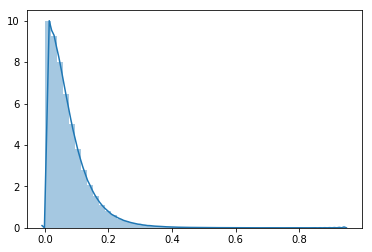

In [37]:
plt.figure()
sns.distplot(diffs)
plt.show()

### Save the model

In [38]:
# print("Saving {}".format(model_name))
# full_name = os.path.join(models_path, model_name)
# os.makedirs(full_name)

# autoencoder.save(os.path.join(full_name, "autoencoder.h5"))
# encoder.save(os.path.join(full_name, "encoder.h5"))

### Analyze the weights

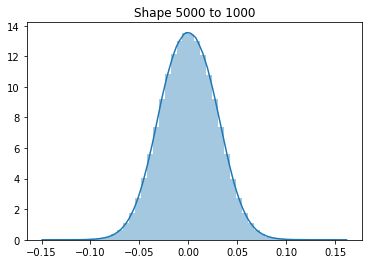

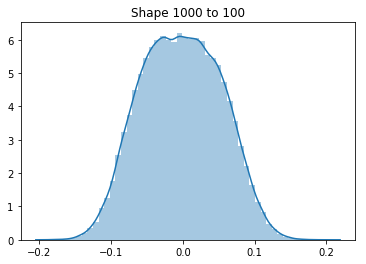

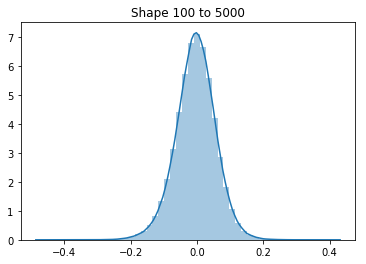

In [39]:
weights = autoencoder.get_weights()

for ws in weights:
    if len(ws.shape) != 2:
        continue
    plt.figure()
    sns.distplot(ws.flatten())
    plt.title("Shape {} to {}".format(ws.shape[0], ws.shape[1]))

plt.show()

# Predict staging

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

class KerasEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoder):
        self.encoder = encoder
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.encoder.predict(X)

In [42]:
pipeline = Pipeline(steps=[
    ("classifier", RandomForestClassifier(n_estimators=1000))
])

In [43]:
scoring = {
    'TRUE_ES': make_scorer(utils.tp),
    'TRUE_LS': make_scorer(utils.tn),
    'FALSE_ES': make_scorer(utils.fp),
    'FLASE_LS': make_scorer(utils.fn),
    
    'accuracy': make_scorer(metrics.accuracy_score),
    'sensitivity': make_scorer(metrics.recall_score, average="weighted"),
    'MCC': make_scorer(metrics.matthews_corrcoef),
    'f-score': make_scorer(metrics.f1_score, average="weighted"),
    'auROC': make_scorer(metrics.roc_auc_score, average="weighted")
}

In [44]:
scores = cross_validate(estimator=pipeline, scoring=scoring, n_jobs=10,
                        X=X, y=y, cv=10, return_train_score=False)

In [45]:
def get_confusion_matrix(scores):
    test_TRUE_ES = scores['test_TRUE_ES'].sum()
    test_TRUE_LS = scores['test_TRUE_LS'].sum()
    test_FALSE_ES = scores['test_FALSE_ES'].sum()
    test_FLASE_LS = scores['test_FLASE_LS'].sum()
    
    d = np.array([[test_TRUE_ES, test_FALSE_ES], 
                  [test_FLASE_LS, test_TRUE_LS]])
    return d

def cm_to_df(d):
    r = pd.DataFrame(data=d, index=utils.name_labels, columns=utils.name_labels)
    r.index.name = "Actual"
    r.columns.name = "Predicted"
    return r

def get_aggregate_measures(scores):
    res = {
        'accuracy': scores['test_accuracy'],
        'sensitivity': scores['test_sensitivity'],
        'MCC': scores['test_MCC'],
        'f-score': scores['test_f-score'],
        'auROC': scores['test_auROC']
    }
    return pd.DataFrame.from_dict(res)

In [46]:
get_aggregate_measures(scores).mean()

MCC            0.408533
accuracy       0.725919
auROC          0.692205
f-score        0.714262
sensitivity    0.725919
dtype: float64

In [47]:
cm_to_df(get_confusion_matrix(scores))

Predicted,Early_Stage,Late_Stage
Actual,,
Early_Stage,274,95
Late_Stage,50,112


# Tumor Grading

In [ ]:
X, y, _, _, idx_to_gene_cohort, _ = utils.load_grade_data(X_path, X_meta_path)

# reordering of X genes because it is different from TCGA
idx_to_gene_cohort = idx_to_gene_cohort.sort_values()
X = X[:, idx_to_gene_cohort.index.tolist()]
idx_to_gene_cohort = idx_to_gene_cohort.reset_index(drop=True)

In [ ]:
plt.figure(figsize=(10, 10))
utils.plot_PCA(X, y)
plt.title("KIRC dataset", fontsize=30)
plt.show()

In [ ]:
X_t = X[:, genes_top_idxs]

scaler.fit(X_t)
X_t = scaler.transform(X_t)

In [ ]:
plt.figure(figsize=(10, 10))
utils.plot_PCA(X_t, y)
plt.title("KIRC dataset after top gene selection", fontsize=30)
plt.show()

In [ ]:
encoded_cohort = encoder.predict(X_t)

In [ ]:
plt.figure(figsize=(10, 10))
utils.plot_PCA(encoded_cohort, y)
plt.title("KIRC dataset after encoding", fontsize=30)
plt.show()

## Scores

### Embedded features

In [ ]:
scores = cross_validate(estimator=pipeline, scoring=scoring, n_jobs=10,
                        X=encoded_cohort, y=y, cv=10, return_train_score=False)

In [ ]:
get_aggregate_measures(scores).mean()

In [ ]:
cm_to_df(get_confusion_matrix(scores))

In [ ]:
encoded_cohort

### Nothing

In [ ]:
scores = cross_validate(estimator=pipeline, scoring=scoring, n_jobs=10,
                        X=X, y=y, cv=10, return_train_score=False)

In [ ]:
get_aggregate_measures(scores).mean()

In [ ]:
cm_to_df(get_confusion_matrix(scores))